# Projeto 1 - Ciência dos Dados

Nome: Gabriela Mitu

Nome: Fernando Avila

___
## Classificador automático de sentimento


## Introdução

A temática que será abordada na pesquisa é referente ao personagem Sonic, dado que o assunto está em alta em razão do recente lançamento do filme relacionado a ele.

Para adqurir informações interessantes para as empresas envolvidas tanto com o filme como com o jogo que deu origem ao personagem, será utilizada a rede social Twitter. Entretanto, em meio a todo o conteúdo que será adquirido nela, há uma grande quantidade de dados irrelevantes e que devem ser filtrados.

Desta forma, será construído um classificador Naive-Bayes capaz de fazer esse trabalho de filtragem.


## Preparando o ambiente no jupyter:

In [250]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tweepy
import math
import os.path
import json
from random import shuffle
import nltk
from nltk.corpus import stopwords

In [251]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Insper\3ºSemestre\CieDadosDP\Projeto1\CDados2020_Projeto1


### Planilha de dados

Para criar o classificador Naive Bayes, os seguintes passos foram seguidos:
- Elaboração deplanilhas do excel de treinamento e teste com dados do Twitter sobre o produto "Android"
- Classificação manual dos dados da planilha (ver: Projeto2-excel.ipynb).
Na coluna de Categoria, foram separados 4 tipos de classificação: Irrelevante, Pouco relevante, Relevante e Muito Relevante. Como critério para identificar cada tipo foi utilizada a definição a seguir:


**Relevante**:
- Críticas (construtivas ou mesmo pequenos feedbacks) sobre tanto o filme como os jogos relacionados ao personagem, pois o lançamento do filme pode ter acarretado no retorno da popularidade de alguns dos jogos da franquia.
- Sugestões/novas ideias (filme/jogo)


**Muito Irrelevante**:
- Situações pessoais
- Comentários aleatórios não referenciais ao personagem (filme/jogo) ou que não sustentam nenhuma relevância.


**Irrelevante**:
- Propagandas
- Anunciar a exibição em algum site
- Links relacionados ao tema.

**Relevante_filme**
- Subcategoria de "Relevante" para a melhoria do classificador sobre o filme
- Críticas (construtivas ou mesmo pequenos feedbacks) sobre apenas o filme
- Sugestões/novas ideias para o filme

**Relevante_jogo**
- Subcategoria de "Relevante" para a melhoria do classificador sobre jogos da franquia Sonic
- Críticas (construtivas ou mesmo pequenos feedbacks) sobre apenas a franquia do jogo
- Sugestões/novas ideias para a franquia de jogos

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [252]:
tweets_treinamento = pd.read_excel('Sonic.xlsx',sheet_name=0)
tweets_treinamento["Relevancia"] = tweets_treinamento["Relevancia"].replace(0,"Irrelevante")
tweets_treinamento["Relevancia"] = tweets_treinamento["Relevancia"].replace(1,"Relevante")
tweets_treinamento["Relevancia"] = tweets_treinamento["Relevancia"].replace(2,"Infos")

tweets_treinamento["Relevancia_2"] = tweets_treinamento["Relevancia_2"].replace(0,"Muito Irrelevante")
tweets_treinamento["Relevancia_2"] = tweets_treinamento["Relevancia_2"].replace(1,"Relevante_filme")
tweets_treinamento["Relevancia_2"] = tweets_treinamento["Relevancia_2"].replace(2,"Irrelevante")
tweets_treinamento["Relevancia_2"] = tweets_treinamento["Relevancia_2"].replace(3,"Relevante_jogo")

tweets_treinamento.head()

,Treinamento,Relevancia,Relevancia_2
0,rt @oldvx: opa opa opa ta tirando a roupinha p...,Irrelevante,Muito Irrelevante
1,sonic é o filme mais fofo de 2020,Relevante,Relevante_filme
2,opinião impopular: mario é melhor que sonic,Relevante,Relevante_jogo
3,@amacalister2 cabe a mim aceitar que eu sou bu...,Irrelevante,Muito Irrelevante
4,"o novo filme do sonic é do caralhooo, recomendo!!",Relevante,Relevante_filme


In [253]:
tweets_teste= pd.read_excel("Sonic.xlsx",sheet_name=1) 

tweets_teste["Relevancia"] = tweets_teste["Relevancia"].replace(0,"Irrelevante")
tweets_teste["Relevancia"] = tweets_teste["Relevancia"].replace(1,"Relevante")
tweets_teste["Relevancia"] = tweets_teste["Relevancia"].replace(2,"Infos")

tweets_teste["Relevancia_2"] = tweets_teste["Relevancia_2"].replace(0,"Irrelevante")
tweets_teste["Relevancia_2"] = tweets_teste["Relevancia_2"].replace(1,"Relevante_filme")
tweets_teste["Relevancia_2"] = tweets_teste["Relevancia_2"].replace(2,"Infos")
tweets_teste["Relevancia_2"] = tweets_teste["Relevancia_2"].replace(3,"Relevante_jogo")


tweets_teste.head()

,Teste,Relevancia,Relevancia_2
0,@kaosnxi @sonic_incel @rolandinho frango se co...,Irrelevante,Irrelevante
1,https://t.co/87srl06nwo\n\nhttps://t.co/glb5nt...,Irrelevante,Irrelevante
2,achei o filme do sonic tão fofo 🥰,Relevante,Relevante_filme
3,@khoroshw e vamos de sonic como melhor filme,Relevante,Relevante_filme
4,eles vão fechar até os cinemas da minha cidade...,Irrelevante,Irrelevante


## Limpeza das bases

Para a obtenção de melhores resultados, uma limpeza de bases foi feita. Esta consistia na remoção de caracteres que não interferiam no significado dos comentários, mas poderiam dificultar a classificação. Sem a limpeza, o classificador poderia carecterizar dados semelhantes como distintos.

In [254]:
def limpeza(tweets, coluna):
    tweets[coluna] = tweets[coluna].apply(lambda x: x.lower())

    for frase in tweets[coluna]:
        frase_split = frase.split(" ")
        for palavra in frase_split:
            if len(palavra) == 1:
                frase_split.remove(palavra)



    nltk.download('stopwords')
    stop = stopwords.words('portuguese')
    stop_list = ["?", "de", "é", "á", "à", "ao", "a", "o", "é", "rt", '"', "“", "'", ",", ":", ".", "(", ")", "!", "$", "%", "*", "&", "-", "+", "=", "/"]
    stop.extend(stop_list)
    tweets[coluna] = [' '.join([w for w in x.lower().split() if w not in stop]) 
        for x in tweets[coluna].tolist()]
    
    
        

    tweets[coluna] = tweets[coluna].str.replace("  "," ")
    tweets[coluna] = tweets[coluna].str.replace(",","")
    tweets[coluna] = tweets[coluna].str.replace("?","")
    tweets[coluna] = tweets[coluna].str.replace("'","")
    tweets[coluna] = tweets[coluna].str.replace('"',"")
    tweets[coluna] = tweets[coluna].str.replace("“","")
    tweets[coluna] = tweets[coluna].str.replace(":","")
    tweets[coluna] = tweets[coluna].str.replace(".","")
    tweets[coluna] = tweets[coluna].str.replace(")","")
    tweets[coluna] = tweets[coluna].str.replace("(","")
    tweets[coluna] = tweets[coluna].str.replace("!","")
    tweets[coluna] = tweets[coluna].str.replace("$","")
    tweets[coluna] = tweets[coluna].str.replace("%","")
    tweets[coluna] = tweets[coluna].str.replace("*","")
    tweets[coluna] = tweets[coluna].str.replace("&","")
    tweets[coluna] = tweets[coluna].str.replace("-","")
    tweets[coluna] = tweets[coluna].str.replace("+","")
    tweets[coluna] = tweets[coluna].str.replace("=","")
    tweets[coluna] = tweets[coluna].str.replace("/","")
    tweets[coluna] = tweets[coluna].str.replace("@","")
    tweets[coluna] = tweets[coluna].str.replace("|","")

    return pd.DataFrame(tweets)

## Implementação do classificador

### Classificador Naive Bayes

O algoritmo “Naive Bayes” é um classificador probabilístico criado com base no “Teorema de Bayes”. A denominação "naive"  se baseia no fato de que o classificador considera as variáveis estudadas como independentes. O algoritmo consegue encontrar uma probabilidade a posteriori a partir da probabilidade a priori a partir da seguinte relação:

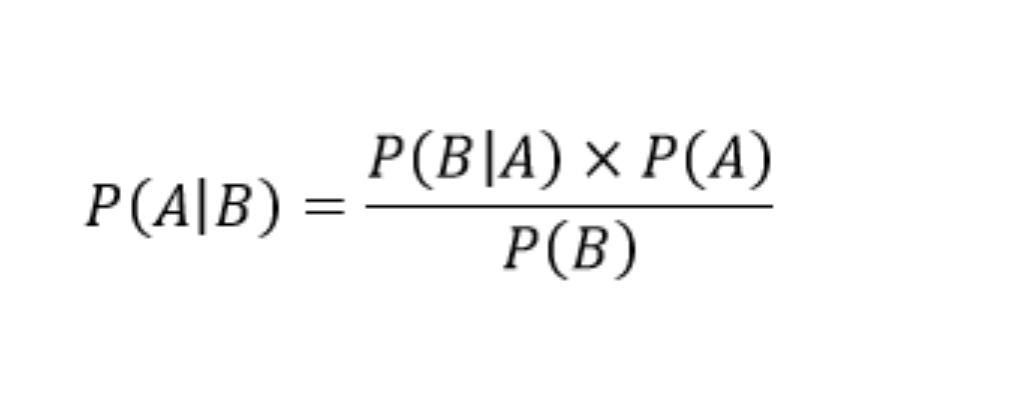

- P(B|A): probabilidade de B acontecer dado que A ocorreu 
- P(A): probabilidade de A ocorrer 
- P(B): probabilidade de B ocorrer

### Suavização de Laplace

Como algumas palavras não existem nos tweets irrelevantes, se o Teorema de Bayes fosse seguido normalmente, haveria uma multiplicação de probabilidades por zero. Para evitar tal problema, foi utilizada a técnica de suavização de Laplace. Ela consiste no seguinte procedimento:


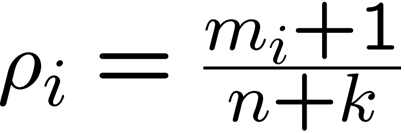

Na imagem, m é a frequência absoluta (no caso da palavra), n é o numero de termos no documento (quantidade de palavras e k é o número de termos da categoria a ser estudada.


Para realizar a suavização, foi criado um dicionário para cada categoria. Todas as palavras do conjunto foram adicionadas nesses dicionários, com valor inicial igual a um. Depois, o número de vezes que uma palavra aparece foi acrescentado ao valor da palavra correspondente

In [255]:
tweets = limpeza(tweets_treinamento, "Treinamento")

irrel = tweets['Treinamento'][tweets['Relevancia'] == "Irrelevante"]
rele = tweets['Treinamento'][tweets['Relevancia'] == "Relevante"]
infos = tweets['Treinamento'][tweets['Relevancia'] == "Infos"]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Frequência absoluta - relevante, irrelevante, informação

In [256]:
conteudo = []
for t in tweets["Treinamento"]: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
            
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalt=freq.sum()
print("Frequência absoluta (relevante, irrelevante, infos): ", totalt)
dict_tot =freq.to_dict()


Frequência absoluta (relevante, irrelevante, infos):  3171


## Dicionário da categoria relevante, frequência absoluta e relativa


In [257]:
conteudo = []
for t in rele: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totrele=freq.sum()
print("Frequência absoluta: ",totrele)
di_rele=freq.to_dict()
frele=totrele/totalt
print("Frequência relativa: ",frele)

Frequência absoluta:  942
Frequência relativa:  0.29706717123935666


In [258]:
dicionario_relevante={}
for p in dict_tot.keys():
    dicionario_relevante[p]=1
for palavra in di_rele:
    dicionario_relevante[palavra]+=di_rele[palavra]
print("Dicionário - categoria relevante:")

m=0
for k in dicionario_relevante:
    while m<1:
        print ("Termo mais utilizado do dicionário: ",k + ": " + str(dicionario_relevante[k]) + " vezes")
        m+=1
        
#dicionario_relevante

Dicionário - categoria relevante:
Termo mais utilizado do dicionário:  sonic: 84 vezes


## Dicionário da categoria irrelevante, frequência absoluta e relativa

In [259]:
conteudo = []
for t in irrel: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totirr=freq.sum()
print("Frequência absoluta: ",totirr)
di_irr=freq.to_dict()
firr=totirr/totalt
print("Frequência relativa: ",firr)

Frequência absoluta:  2017
Frequência relativa:  0.6360769473352255


In [260]:
dicionario_irrelevante={}
for p in dict_tot.keys():
    dicionario_irrelevante[p]=1
for palavra in di_irr:
    dicionario_irrelevante[palavra]+=di_irr[palavra]
print("Dicionário - categoria irrelevante")

m=0
for k in dicionario_irrelevante:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_irrelevante[k]) + " vezes")
        m+=1

#dicionario_irrelevante

Dicionário - categoria irrelevante
Termo mais utilizado dicionário:  sonic: 188 vezes


## Dicionário da categoria informação, frequência absoluta e relativa

In [261]:
conteudo = []
for t in infos: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totinfo=freq.sum()
print("Frequência absoluta: ",totinfo)
di_info=freq.to_dict()
finfo=totinfo/totalt
print("Frequência relativa: ",finfo)

Frequência absoluta:  212
Frequência relativa:  0.06685588142541785


In [262]:
dicionario_informacao={}
for p in dict_tot.keys():
    dicionario_informacao[p]=1
for palavra in di_info:
    dicionario_informacao[palavra]+=di_info[palavra]
print("Dicionário - categoria informação")

m=0
for k in dicionario_informacao:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_informacao[k]) + " vezes")
        m+=1

#dicionario_irrelevante

Dicionário - categoria informação
Termo mais utilizado dicionário:  sonic: 22 vezes


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [263]:
irrel ={}
rel ={}
info = {}

todas_palavras=dict_tot.keys()
for palavra in todas_palavras:
    irrel[palavra]= dicionario_irrelevante[palavra]/(len(todas_palavras)+(totirr))#suavização de Laplace
    rel[palavra]= dicionario_relevante[palavra]/(len(todas_palavras)+(totrele))
    info[palavra]= dicionario_informacao[palavra]/(len(todas_palavras)+(totinfo))


In [264]:
dftw = limpeza(tweets_teste,"Teste")
tweets=dftw["Teste"]
chute = []

for frase in tweets:
    prob_irrel=1
    prob_rel=1
    prob_info=1
    y = frase.split(" ")
    for palavra in y: 
        if palavra in irrel:
            prob_irrel *= irrel[palavra]
        else:
            prob_irrel *= 1/ (len(todas_palavras)+(totirr))
        
        if palavra in rel:
            prob_rel *= rel[palavra]
        else:
            prob_rel *= 1/ (len(todas_palavras)+(totrele))
            
        if palavra in info:
            prob_info *= info[palavra]
        else:
            prob_info *= 1/ (len(todas_palavras)+(totinfo))
       
    PIR= (firr*prob_irrel)
    PR = (frele*prob_rel)
    PIN = (finfo*prob_info)

    if PR>=PIR and PR>=PIN:
        chute.append("Relevante")
    elif PIN >= PR and PIN >= PIR:
        chute.append("Informacao")
    else:
        chute.append("Irrelevante")


dftw["Chute"]=chute
dftw.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Teste,Relevancia,Relevancia_2,Chute
0,kaosnxi sonic_incel rolandinho frango corte ún...,Irrelevante,Irrelevante,Informacao
1,httpstco87srl06nwo httpstcoglb5ntj1uc httpstco...,Irrelevante,Irrelevante,Informacao
2,achei filme sonic tão fofo 🥰,Relevante,Relevante_filme,Relevante
3,khoroshw vamos sonic melhor filme,Relevante,Relevante_filme,Relevante
4,vão fechar cinemas cidade adeus oportunidade a...,Irrelevante,Irrelevante,Relevante


## Análise do desempenho

### Tabela de distribuição conjunta - previsão do programa e classificação real

In [265]:
matriz = pd.crosstab(dftw["Relevancia"], dftw["Chute"], margins=True, normalize=True, rownames=["Real"], colnames=["Predito"])
matriz

Predito,Informacao,Irrelevante,Relevante,All
Real,,,,
Infos,0.004831,0.033816,0.014493,0.05314
Irrelevante,0.115942,0.405797,0.212560,0.73430
Relevante,0.019324,0.053140,0.140097,0.21256
All,0.140097,0.492754,0.367150,1.00000


### Previsão

In [266]:
numero_acerto = (dftw["Relevancia"] == dftw["Chute"]).value_counts()
eficiencia=numero_acerto[True]/len(dftw)
print("O classificador acertou as previsões em {} dos casos".format(eficiencia*100))

O classificador acertou as previsões em 54.589371980676326 dos casos


### Heatmap

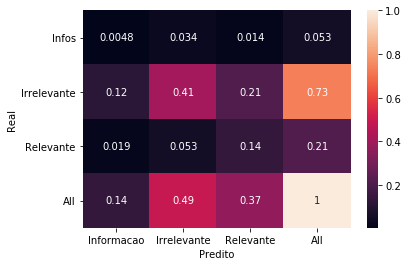

In [267]:
import pandas as pd
import seaborn as sn

sn.heatmap(matriz, annot=True)

A fim de melhorar a visualização de dados, foi criado um heatmap com as informações adquiridas com os códigos anteriores. Desta forma, há a presença de todo um data set com ambas as variáveis instantaneamente, ou seja, há melhor visualização da correlação da matriz (tabela de distribuição conjunta).

Como resposta do classficador, houve cerca de 54,59% de acertos. Entretanto, para melhorar o desempenho dele, foi feito um outro teste, porém, desta vez, acrescentando uma nova variável categórica, assim determinadas palavras se tornariam mais específicas para cada categoria definida.

## Categoria Naive-Bayes com 4 categorias

In [268]:
tweets = limpeza(tweets_treinamento, "Treinamento")

tweets_mirrel=tweets['Treinamento'][tweets['Relevancia_2'] == "Muito Irrelevante"]
tweets_relf=tweets['Treinamento'][tweets['Relevancia_2'] == "Relevante_filme"]
tweets_irrel=tweets['Treinamento'][tweets['Relevancia_2'] == "Irrelevante"]
tweets_relj=tweets['Treinamento'][tweets['Relevancia_2'] == "Relevante_jogo"]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Frequência absoluta

In [269]:
conteudo = []
for t in tweets["Treinamento"]: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
            
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalt=freq.sum()
print("Frequência absoluta (relevante_filme, irrelevante, muito irrelevante, relevante_jogos): ", totalt)
dict_tot =freq.to_dict()


Frequência absoluta (relevante_filme, irrelevante, muito irrelevante, relevante_jogos):  3148


## Frequências absoluta e relativa "muito irrelevante"

In [270]:
conteudo = []
for t in tweets_mirrel: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalmir=freq.sum()
print("Frequência absoluta (Irrelevante): ",totalmir)
dict_mirrel=freq.to_dict()
freq_rel_mirr=totalmir/totalt
print("Frequência relativa (Irrelevante): ",freq_rel_mirr)


Frequência absoluta (Irrelevante):  2004
Frequência relativa (Irrelevante):  0.636594663278272


In [271]:
dicionario_mirrel={}
for p in dict_tot.keys():
    dicionario_mirrel[p]=1
for palavra in dict_mirrel:
    dicionario_mirrel[palavra]+=dict_mirrel[palavra]

print("Dicionário - categoria irrelevante")
m=0
for k in dicionario_mirrel:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_mirrel[k]) + " vezes")
        m+=1

Dicionário - categoria irrelevante
Termo mais utilizado dicionário:  sonic: 188 vezes


## Palavras na categoria "relevante_filme"

In [272]:
conteudo = []
for t in tweets_relf: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalrf=freq.sum()
print("Frequência absoluta (Relevante_filme): ",totalrf)
dict_relf=freq.to_dict()
freq_rel_relf=totalrf/totalt
print("Frequência relativa (Relevante_filme): ",freq_rel_relf)



Frequência absoluta (Relevante_filme):  598
Frequência relativa (Relevante_filme):  0.18996188055908514


In [273]:
dicionario_relf={}
for p in dict_tot.keys():
    dicionario_relf[p]=1
for palavra in dict_relf:
    dicionario_relf[palavra]+=dict_relf[palavra]
dicionario_relf

print("Dicionário - categoria relevante_filme")

m=0
for k in dicionario_relf:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_relf[k]) + " vezes")
        m+=1

Dicionário - categoria relevante_filme
Termo mais utilizado dicionário:  sonic: 54 vezes


## Palavras na categoria "irrelevante"

In [274]:
conteudo = []
for t in tweets_irrel: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalir=freq.sum()
print("Frequência absoluta (Irrelevante): ",totalir)
dict_irrel=freq.to_dict()
freq_rel_irr=totalir/totalt
print("Frequência relativa (Irrelevante): ",freq_rel_irr)


Frequência absoluta (Irrelevante):  212
Frequência relativa (Irrelevante):  0.06734434561626429


In [275]:
dicionario_irrel={}
for p in dict_tot.keys():
    dicionario_irrel[p]=1
for palavra in dict_irrel:
    dicionario_irrel[palavra]+=dict_irrel[palavra]

print("Dicionário - categoria irrelevante")
m=0
for k in dicionario_irrel:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_irrel[k]) + " vezes")
        m+=1

Dicionário - categoria irrelevante
Termo mais utilizado dicionário:  sonic: 22 vezes


## Palavras na categoria "relevante_jogo"

In [276]:
conteudo = []
for t in tweets_relj: 
    pal = t.split()
    for p in pal:
            conteudo.append(p)
texto=" ".join(conteudo)
series= pd.Series(texto.split())
freq = series.value_counts()
totalrj=freq.sum()
print("Frequência absoluta (Relevante_filme): ",totalrj)
dict_relj=freq.to_dict()
freq_rel_relj=totalrj/totalt
print("Frequência relativa (Relevante_filme): ",freq_rel_relj)



Frequência absoluta (Relevante_filme):  334
Frequência relativa (Relevante_filme):  0.10609911054637865


In [277]:
dicionario_relj={}
for p in dict_tot.keys():
    dicionario_relj[p]=1
for palavra in dict_relj:
    dicionario_relj[palavra]+=dict_relj[palavra]
dicionario_relj

print("Dicionário - categoria relevante_filme")

m=0
for k in dicionario_relj:
    while m<1:
        print ("Termo mais utilizado dicionário: ", k + ": " + str(dicionario_relj[k]) + " vezes")
        m+=1

Dicionário - categoria relevante_filme
Termo mais utilizado dicionário:  sonic: 31 vezes


## Implementação do classificador Naive Bayes

In [278]:
mirrel ={}
relf ={}
irrel ={}
relj = {}

todas_palavras=dict_tot.keys()
for palavra in todas_palavras:
    mirrel[palavra]= dicionario_mirrel[palavra]/(len(todas_palavras)+(totalmir))
    relf[palavra]= dicionario_relf[palavra]/(len(todas_palavras)+(totalrf))
    irrel[palavra]= dicionario_irrel[palavra]/(len(todas_palavras)+(totalir))
    relj[palavra]= dicionario_relj[palavra]/(len(todas_palavras)+(totalrj))



In [279]:
dftw = limpeza(tweets_teste,"Teste")
tweets=dftw["Teste"]
chute = []

for frase in tweets:
    prob_mirrel=1
    prob_relf=1
    prob_irrel=1
    prob_relj=1
    y = frase.split(" ")
    for palavra in y: 
        if palavra in mirrel:
            prob_mirrel *= mirrel[palavra]
        else:
            prob_mirrel *= 1/ (len(todas_palavras)+(totalmir))
        
        if palavra in relf:
            prob_relf *= relf[palavra]
        else:
            prob_relf *= 1/ (len(todas_palavras)+(totalrf))
            
        if palavra in irrel:
            prob_irrel *= irrel[palavra]
        else:
            prob_irrel *= 1/ (len(todas_palavras)+(totalir))
            
        if palavra in relj:
            prob_relj*= relj[palavra]
        else:
            prob_relj *= 1/(len(todas_palavras)+(totalrj))
         
    PMI= (freq_rel_mirr*prob_mirrel)
    PRF =(freq_rel_rf*prob_relf)
    PI = (freq_rel_irr*prob_irrel)
    PRJ=( freq_rel_relj*prob_relj)

    if PRJ >= PI and PRJ>=PRF and PRJ>=PMI:
        chute.append("Relevante_jogo")

    elif PI>=PMI and PI>=PRF:
        chute.append("Irrelevante")

    elif PRF>=PMI:
        chute.append("Relevante_filme")
    else:
        chute.append("Muito Irrelevante")


dftw["Chute"]=chute
dftw.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Teste,Relevancia,Relevancia_2,Chute
0,kaosnxi sonic_incel rolandinho frango corte ún...,Irrelevante,Irrelevante,Irrelevante
1,httpstco87srl06nwo httpstcoglb5ntj1uc httpstco...,Irrelevante,Irrelevante,Relevante_jogo
2,achei filme sonic tão fofo 🥰,Relevante,Relevante_filme,Relevante_filme
3,khoroshw vamos sonic melhor filme,Relevante,Relevante_filme,Relevante_filme
4,vão fechar cinemas cidade adeus oportunidade a...,Irrelevante,Irrelevante,Relevante_filme


In [280]:
dftw.head()

,Teste,Relevancia,Relevancia_2,Chute
0,kaosnxi sonic_incel rolandinho frango corte ún...,Irrelevante,Irrelevante,Irrelevante
1,httpstco87srl06nwo httpstcoglb5ntj1uc httpstco...,Irrelevante,Irrelevante,Relevante_jogo
2,achei filme sonic tão fofo 🥰,Relevante,Relevante_filme,Relevante_filme
3,khoroshw vamos sonic melhor filme,Relevante,Relevante_filme,Relevante_filme
4,vão fechar cinemas cidade adeus oportunidade a...,Irrelevante,Irrelevante,Relevante_filme


## Resultados do teste e verificação de performance

In [281]:

numero_acerto = (dftw["Relevancia_2"] == dftw["Chute"]).value_counts()
eficiencia=numero_acerto[True]/len(dftw)
print("O classificador acertou as previsões em {} dos casos".format(eficiencia*100))


O classificador acertou as previsões em 16.908212560386474 dos casos


___
### Concluindo

A análise demonstrou que o classificador Naive Bayes é uma ótima ferramenta para prever possibilidades baseadas em dados previamente processados. Por conta de sua eficácia, essa ferramenta de Machine Learning é usada em cenários distintos. Dentre eles:
- Filtro Spam em emails
- Classificação de gostos para recomendações personalizadas (por exemplo filmes ou músicas)
- Reconhecimento facial 
- Diagnósticos médicos

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que periodicamente realiza análise de sentimento e visualiza estes dados

Para o aperfeiçoamento do machine learning, pode-se tomar como possibilidade o aumento da base de treinamento e classificá-la com critérios mais rígidos, promovendo resultados com maior proximidade com a realidade.

O índice de acerto geral resultante pode ser considerado alto.
Entretanto, nota-se que nas categorias de maior relevância, o classificador obteve um pequeno acerto percentual.
Uma metodologia interessante para melhorar tal indice foi proposta no artigo "Indonesian News Classification Using Naïve Bayes and Two-Phase Feature Selection Model"
, da Faculty of Information Technology, Institut Teknologi Sepuluh Nopember.
O estudo propõe implementar o classificador Naive Bayes em duas fases. Na primeira, são classificados dois grupos: relevante e irrelevante. Depois, o grupo considerado relevante é dividido em mais categorias, os níveis de relevância. Segundo o artigo publicado, tal metodologia melhora a precisão do classificador, principalmente nas subcategorias.

Um grande problema na implementação do classificador é a presença de sarcasmo em alguns comentários, podendo ocasionar falsos positivos 
O artigo 'Sentiment Analysis Using Naïve Bayes Classifier' propõe uma solução para essa situação. Tal solução consiste em uma abordagem multifacetada, composta pelos seguintes procedimentos: 
- Marcação de tags #sarcastico ou #sarcasmo nos tweets;
- Análise de contrastes na densidade lexical (proporção entre adjetivos, substantivos, etc.);
- Identificação de hipérboles (exclamações, repetição de palavras intensificadoras (como muito, demais, etc) e palavras extendidas (como muuuuuuuito));
- Consideração de emojis 


Segundo o artigo, outro classificador Naive Bayes poderia ser usado para identificar o sarcasmo. O mesmo procedimento do projeto deveria ser seguido, em que o classificador "aprenderia" a identificar mensagens sarcásticas por meio de uma amostra classificada

___
## Referências

- Material disponível nos slides e jupyter no Blackboard

- https://stackoverflow.com/questions/12286607/making-heatmap-from-pandas-dataframe

- https://twitter.com/home?lang=pt-br

- [Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

- [A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

https://www.google.com/url?sa=t&source=web&rct=j&url=https://www.ijitee.org/wp-content/uploads/papers/v8i8/H6330068819.pdf&ved=2ahUKEwiv1smT8NLkAhXkHrkGHSaGD_4QFjACegQIDhAH&usg=AOvVaw0famfei5kKkpmWVm8AqKIr
Indonesian News Classification Using Naïve Bayes and Two-Phase Feature Selection Model 
 
 
M. Ali Fauzi*1, Agus Zainal Arifin2, Sonny Christiano Gosaria3, Isnan Suryo Prabowo4 1Faculty of Computer Science, Universitas Brawijaya, Malang, Indonesia 2,3,4Faculty of Information Technology, Institut Teknologi Sepuluh Nopember, Surabaya, Indonesia *Corresponding author, e-mail: moch.ali.fauzi@ub.ac.id 